# Run inference on one frame
Then evaluate

In [174]:
from mmdet3d.apis import LidarDet3DInferencer
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [175]:
# Initialize inferencer
inferencer = LidarDet3DInferencer('pointpillars_kitti-3class')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection3d/v1.0.0_models/pointpillars/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class_20220301_150306-37dc2420.pth


In [176]:
# inference
frame = '006000'
bin_path = '../../mmdetection3d/data/arcs/training/velodyne/' + frame + '.bin'
label_path = '../data/pillar_pred_format_labels/' + frame + '.txt'
inputs = dict(points=bin_path)
points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
predictions = inferencer(inputs)

Output()

In [177]:
print(predictions)

{'predictions': [{'labels_3d': [1, 2, 2, 2, 2, 2], 'scores_3d': [0.37436285614967346, 0.8860181570053101, 0.846523106098175, 0.5451850891113281, 0.4473717212677002, 0.4247516095638275], 'bboxes_3d': [[5.028863430023193, -15.78142261505127, -0.721443772315979, 1.7926948070526123, 0.6943190097808838, 1.7274187803268433, 1.5951296091079712], [2.158820867538452, 25.521644592285156, -2.0219573974609375, 4.410659313201904, 1.713751196861267, 1.4779202938079834, -1.0621992349624634], [10.126334190368652, 26.06059455871582, -1.8438267707824707, 4.386297225952148, 1.6843407154083252, 1.5065099000930786, 2.106016159057617], [29.500598907470703, -14.849691390991211, 0.2762340307235718, 4.206188201904297, 1.5862056016921997, 1.5070021152496338, 2.1125431060791016], [28.044879913330078, -20.803447723388672, 0.47694647312164307, 4.386697292327881, 1.6085255146026611, 1.3169963359832764, 1.2406989336013794], [31.531211853027344, -25.256420135498047, 0.4247567653656006, 4.498119831085205, 1.6615589857

In [178]:
def set_axes_limited(ax, limit=50):
    # Set axes to a fixed range around the origin to limit view to +/- 'limit' meters.
    ax.set_xlim3d([-limit, limit])
    ax.set_ylim3d([-limit, limit])
    ax.set_zlim3d([-limit, limit])

In [179]:
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres, cubes as cubes, etc."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [180]:
# Function to plot the bounding box
def plot_bbox(ax, bbox, color):
    
    x, y, z, dx, dy, dz, yaw = bbox

    
    corners = np.array([
        [x - dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y + dy/2, z + dz/2],
        [x - dx/2, y + dy/2, z + dz/2]
    ])
    

    # Rotate corners around the Z-axis (around their centers)
    rotation_matrix = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,            0,           1]
    ])

    # # Adjust the corners to be about the origin for rotation, then add the [x, y, z] back after rotation
    corners = corners - np.array([x, y, z])
    corners = np.dot(corners, rotation_matrix.T)
    corners += np.array([x, y, z])
    
    # Define the edges of the bounding box
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    # Plot the edges
    for edge in edges:
        ax.plot3D(*zip(corners[edge[0]], corners[edge[1]]), color=color, linewidth=1)

In [182]:
def read_kitti_labels(label_path):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] != 'DontCare':
                bbox = [float(value) for value in parts[8:15]]  # Extract the bounding box dimensions and location
                bboxes.append(bbox)
    return np.array(bboxes)

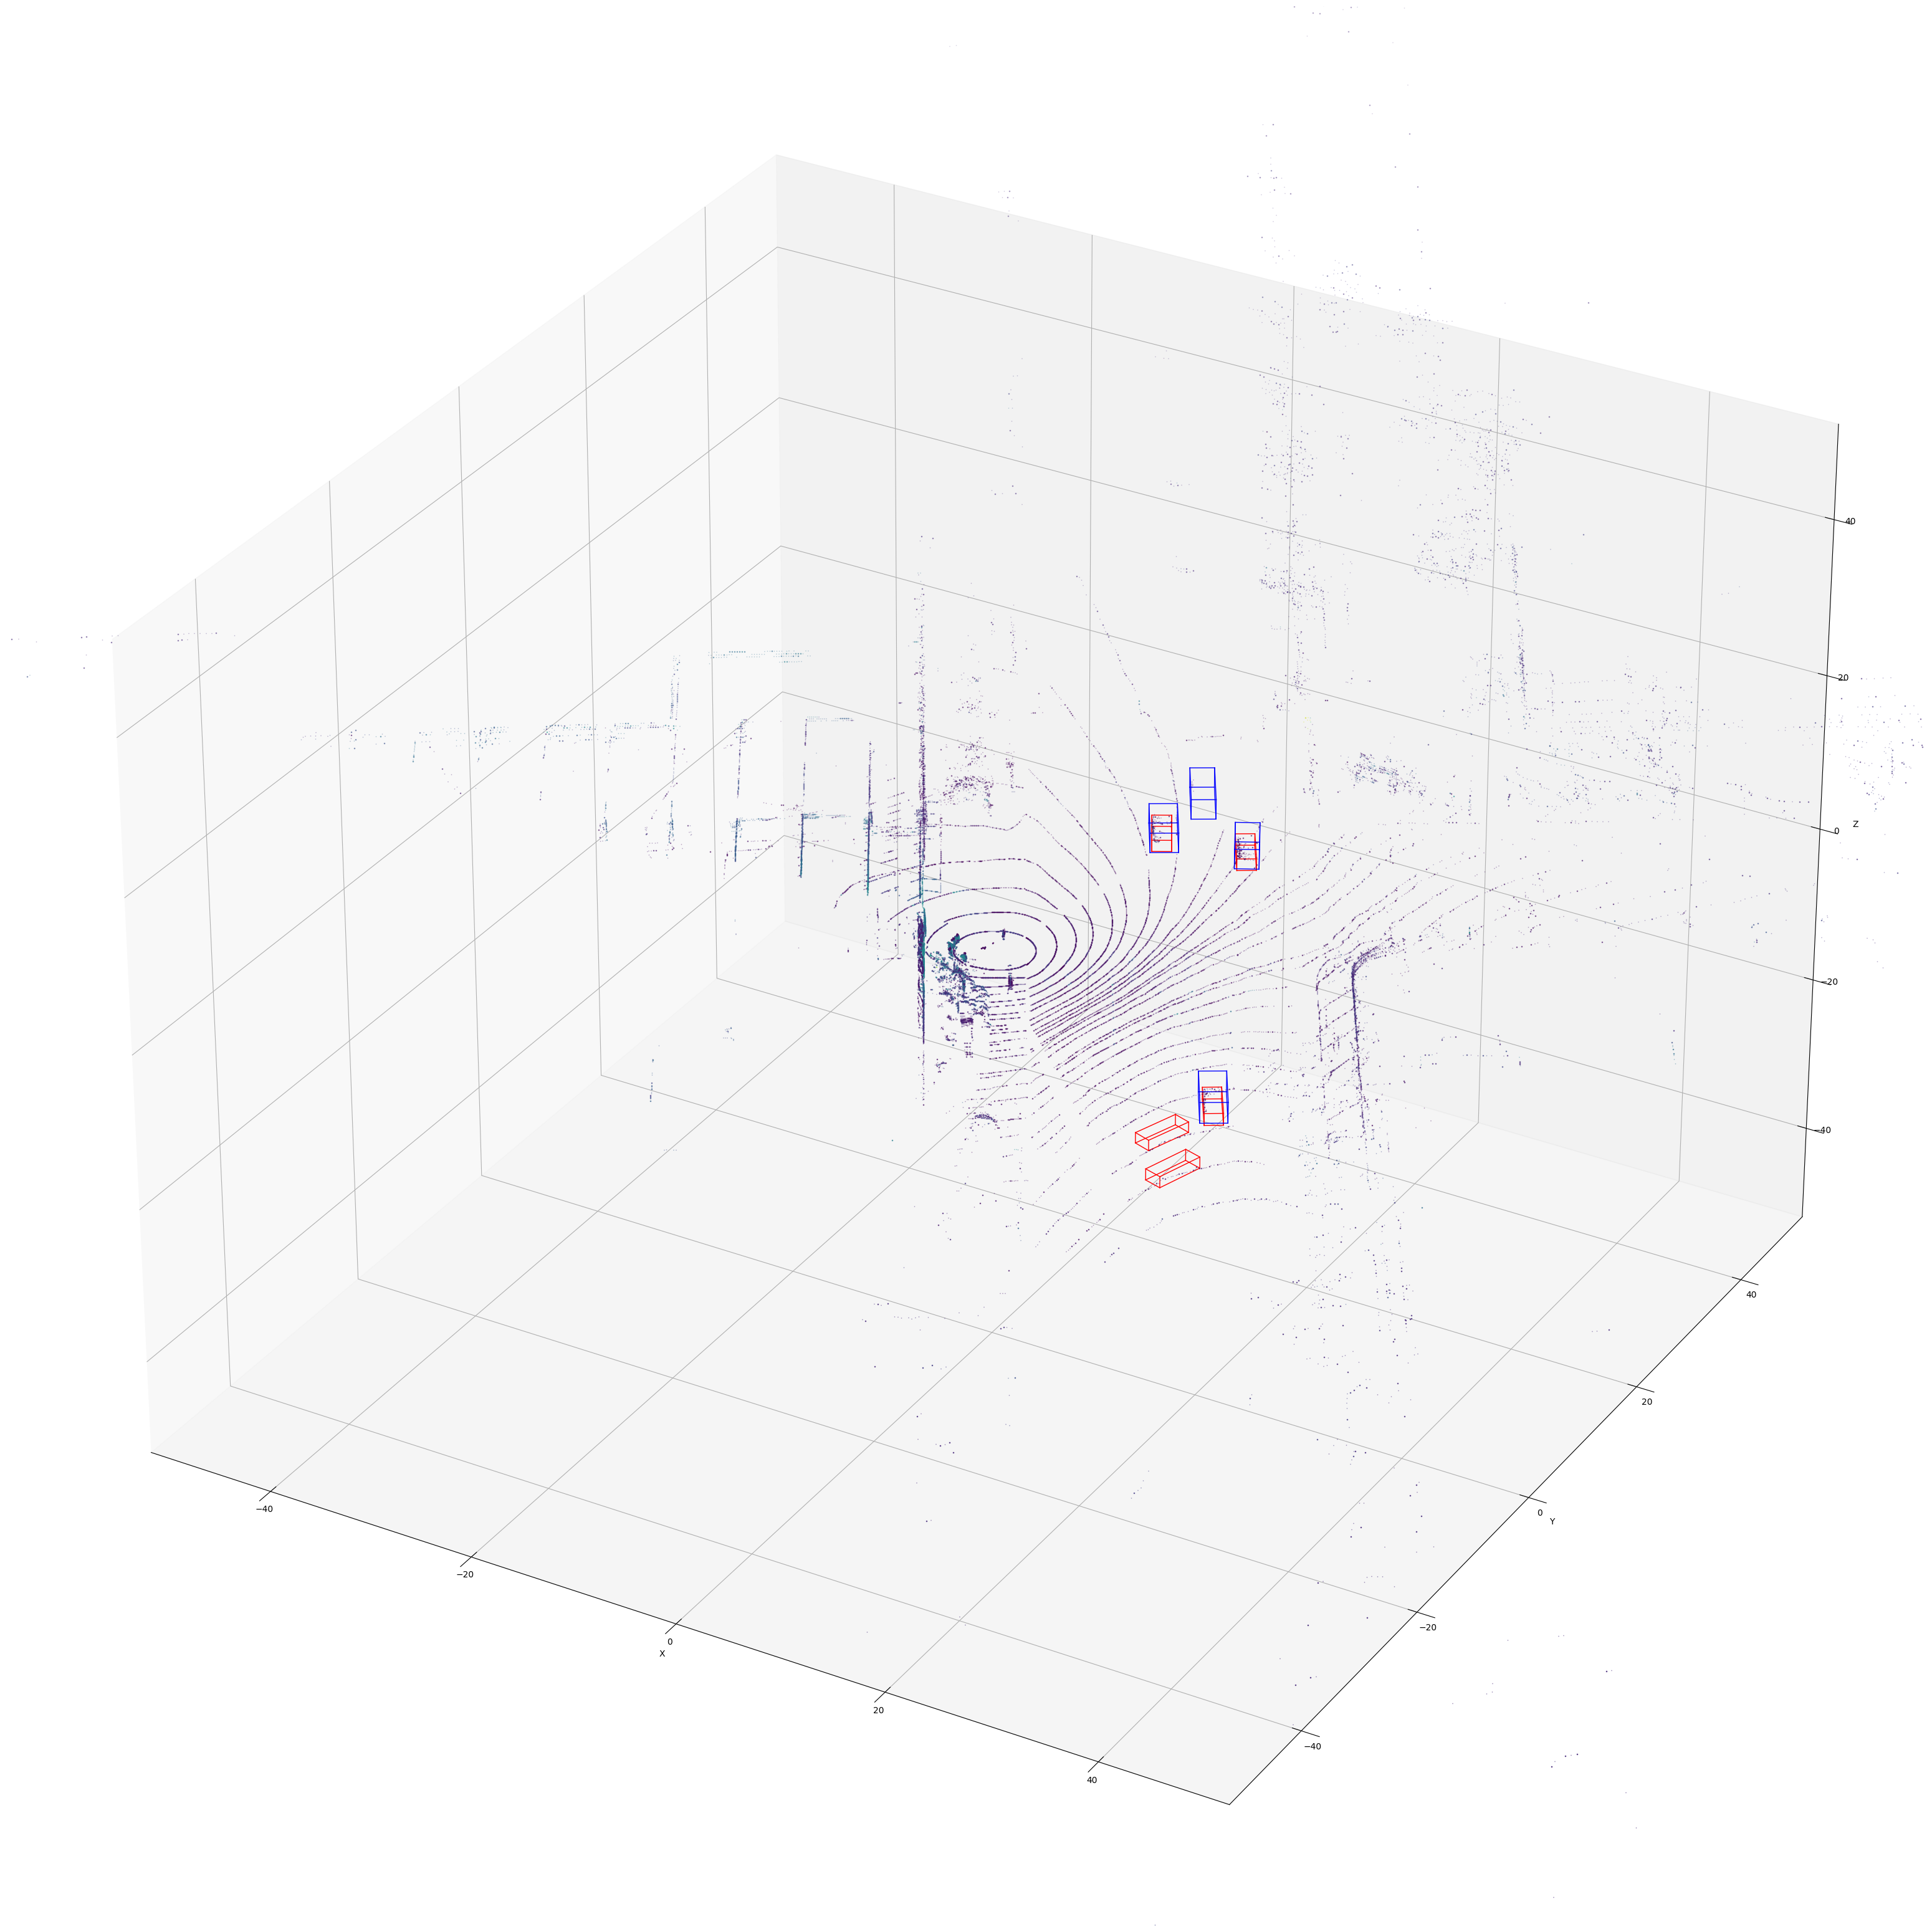

In [184]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, c=points[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box with score above threshold
for pred in predictions['predictions']:
    for label, score, bbox in zip(pred['labels_3d'], pred['scores_3d'], pred['bboxes_3d']):
        if score > score_threshold and label == 2:
            plot_bbox(ax, bbox, 'r')
            
# Plot ground truth
for bbox in read_kitti_labels(label_path):
    plot_bbox(ax, bbox, 'b')
            
# Setting axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)

# Setting axes properties with a limited range
set_axes_limited(ax)

# Show the plot
plt.show()

# Save the figure
fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

In [169]:
# Evaluate prediction
# I have a .txt file with the label and coordinates
# I have this prediction dictionary
# For each prediction over a certain threshold
# Check against all of the labels
# If there is an overlap of a label
# Calculate the UoI
# Otherwise, it's zero?

In [191]:
def parse_predictions(prediction):
    return prediction

In [231]:
def parse_ground_truths(label_path):
#     labels = []
#     with open(label_path, 'r') as file:
#         for line in file:
#             parts = line.strip().split()
#             bbox = []
#             # Add the category as a string
#             bbox.append(parts[0])
#             # Extract the bounding box dimensions and location as 
#             bbox = bbox + [float(value) for value in parts[1:15]]  
#             bbox[2] = int(bbox[2])
#             labels.append(bbox)
#     return np.array(labels)
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            bbox = []
            # Add the category as a string
            bbox.append(parts[0])
            # Extract the bounding box dimensions and location as 
            bbox = bbox + [float(value) for value in parts[1:15]]  
            bbox[2] = int(bbox[2])
            labels.append(bbox)
    return labels

In [170]:
# def calculate_iou(box_pred, box_gt):
#     # Determine the coordinates of the intersection rectangle
#     xA = max(box_pred[0], box_gt[0])
#     yA = max(box_pred[1], box_gt[1])
#     zA = max(box_pred[2], box_gt[2])
#     xB = min(box_pred[3], box_gt[3])
#     yB = min(box_pred[4], box_gt[4])
#     zB = min(box_pred[5], box_gt[5])
    
#     # Compute the volume of intersection
#     interWidth = max(0, xB - xA)
#     interHeight = max(0, yB - yA)
#     interDepth = max(0, zB - zA)
#     interVolume = interWidth * interHeight * interDepth
    
#     # Compute the volume of both the prediction and ground truth boxes
#     boxAVolume = (box_pred[3] - box_pred[0]) * (box_pred[4] - box_pred[1]) * (box_pred[5] - box_pred[2])
#     boxBVolume = (box_gt[3] - box_gt[0]) * (box_gt[4] - box_gt[1]) * (box_gt[5] - box_gt[2])
    
#     # Compute the union volume
#     unionVolume = boxAVolume + boxBVolume - interVolume
    
#     # Compute the intersection over union by taking the intersection
#     # volume and dividing it by the union volume
#     iou = interVolume / unionVolume
    
#     return iou

In [185]:
from scipy.spatial import ConvexHull

In [186]:
def rotate_vertices(vertices, yaw, center):
    c, s = np.cos(yaw), np.sin(yaw)
    R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])  # Rotation matrix for z-axis
    rotated_vertices = np.dot(vertices - center, R.T) + center
    return rotated_vertices

In [187]:
def get_box_vertices(x, y, z, dx, dy, dz, yaw):
    half_dx = dx / 2.0
    half_dy = dy / 2.0
    half_dz = dz / 2.0
    corners = np.array([
        [x + half_dx, y + half_dy, z + half_dz],
        [x + half_dx, y + half_dy, z - half_dz],
        [x + half_dx, y - half_dy, z + half_dz],
        [x + half_dx, y - half_dy, z - half_dz],
        [x - half_dx, y + half_dy, z + half_dz],
        [x - half_dx, y + half_dy, z - half_dz],
        [x - half_dx, y - half_dy, z + half_dz],
        [x - half_dx, y - half_dy, z - half_dz]
    ])
    center = np.array([x, y, z])
    return rotate_vertices(corners, yaw, center)

In [233]:
def calculate_iou(boxA_params, boxB_params):
    verticesA = get_box_vertices(*boxA_params)
    verticesB = get_box_vertices(*boxB_params)
    
    print(verticesA)
    print(verticesB)

    # Creating a convex hull of the combined set of vertices
    all_points = np.vstack([verticesA, verticesB])
    hull = ConvexHull(all_points)

    # Calculate volumes
    volume_intersection = ConvexHull(np.vstack([verticesA, verticesB[hull.vertices]])).volume
    volume_union = ConvexHull(all_points).volume + ConvexHull(verticesA).volume + ConvexHull(verticesB).volume - volume_intersection

    iou = volume_intersection / volume_union
    return iou

In [234]:
def evaluate_model(predictions, ground_truths, threshold=0.5):
    TPs, FPs, FNs = 0, 0, len(ground_truths)
    used_gt = set()
    
    for pred in predictions['predictions']:
        for label, score, bbox in zip(pred['labels_3d'], pred['scores_3d'], pred['bboxes_3d']):
            if score < threshold:
                continue
        
            best_iou = 0
            best_gt = None
            for gt in ground_truths:
                iou = calculate_iou(bbox, gt[8:])
                print(iou)
                if iou > best_iou:
                    best_iou = iou
                    best_gt = gt

            if best_iou > 0.5:  # Example IoU threshold for a match
                if best_gt not in used_gt:
                    used_gt.add(best_gt)
                    TPs += 1
                    FNs -= 1
                else:
                    FPs += 1
            else:
                FPs += 1

    precision = TPs / (TPs + FPs) if TPs + FPs > 0 else 0
    recall = TPs / (TPs + FNs) if TPs + FNs > 0 else 0
    return precision, recall

In [235]:
# Example usage
predictions = parse_predictions(predictions)
ground_truths = parse_ground_truths(label_path)
precision, recall = evaluate_model(predictions, ground_truths)

[[ 3.98113099 24.0127044  -1.28299725]
 [ 3.98113099 24.0127044  -2.76091754]
 [ 2.48429182 23.17818916 -1.28299725]
 [ 2.48429182 23.17818916 -2.76091754]
 [ 1.83334991 27.86510002 -1.28299725]
 [ 1.83334991 27.86510002 -2.76091754]
 [ 0.33651075 27.03058478 -1.28299725]
 [ 0.33651075 27.03058478 -2.76091754]]
[[ 2.00939368 28.55079036 -0.125     ]
 [ 2.00939368 28.55079036 -2.675     ]
 [ 4.63311172 24.07282166 -0.125     ]
 [ 4.63311172 24.07282166 -2.675     ]
 [-0.11311172 27.30717834 -0.125     ]
 [-0.11311172 27.30717834 -2.675     ]
 [ 2.51060632 22.82920964 -0.125     ]
 [ 2.51060632 22.82920964 -2.675     ]]


IndexError: index 8 is out of bounds for axis 0 with size 8

In [199]:
print(precision)
print(recall)

0
0.0
